In [13]:
import gym
import numpy as np
import ray
from gym import Env
from gym.spaces import Discrete, Box, MultiDiscrete
from ray import tune, rllib, air
from ray.rllib.algorithms.ppo import PPOConfig
import matplotlib.pyplot as plt
from ray.tune.registry import register_env
from ray.rllib.utils.pre_checks.env import check_env

In [32]:
a = MultiDiscrete([3,2])
a.sample()

array([1, 0])

In [33]:
np.array([0,0])

array([0, 0])

In [88]:
# define the custom routing grid environemnt
# observation_space
# action_space
# 0 - > move up
# 1 - > move down
# 2 - > move right
# 3 - > move left

class RtGridEnv(Env):
    def __init__(self, length, width):
        self.length = length
        self.width = width
        self.agent_position = np.array([0,0])
        self.goal_position = np.array([self.length - 1, self.width -1])

        self.action_space = Discrete(4)
        self.observation_space = MultiDiscrete([self.length, self.width])

        self.path_x = [0]
        self.path_y = [0]

    def step(self, action):
        if action == 0:  # Up
            if (self.agent_position[1] + 1) <= self.width - 1: # if within the bound, then accept the move
                self.agent_position[1] = self.agent_position[1] + 1
        elif action == 1:  # Down
            if (self.agent_position[1] - 1) >= 0:
                self.agent_position[1] = self.agent_position[1] - 1
        elif action == 2:  # Right
            if (self.agent_position[0] + 1) <= self.length - 1:
                self.agent_position[0] = self.agent_position[0] + 1
        elif action == 3:  # Left
            if (self.agent_position[0] - 1) >= 0:
                self.agent_position[0] = self.agent_position[0] - 1

        done = np.array_equal(self.agent_position, self.goal_position)
        reward = 10 if done else -1

        # Update the agent's path
        self.path_x.append(self.agent_position[0])  
        self.path_y.append(self.agent_position[1])  

        return self.agent_position, reward, done, {}
    
    def render(self):
        # Plot the agent's path
        #print(self.path_x)
        #print(self.path_y)
        plt.plot(self.path_x, self.path_y, 'r')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Agent Path')
        #plt.xlim(0,self.length-1)
        #plt.ylim(0,self.width-1)
        plt.xticks(range(0,self.length))
        plt.yticks(range(0,self.width))
        plt.grid(color='blue', linestyle='--', linewidth=0.5)
        plt.show()

    def reset(self):
        self.agent_position = np.array([0,0])
        self.path_x = [0]
        self.path_y = [0]
        return self.agent_position

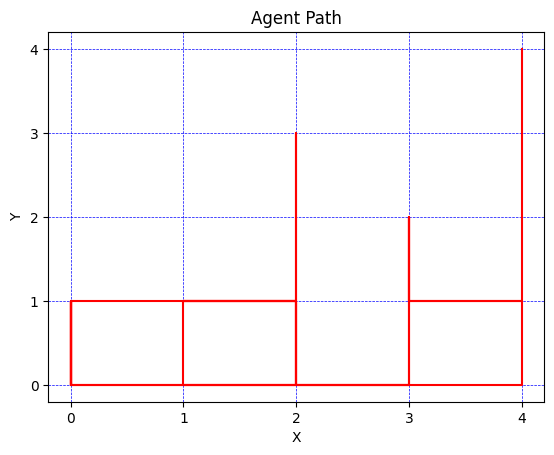

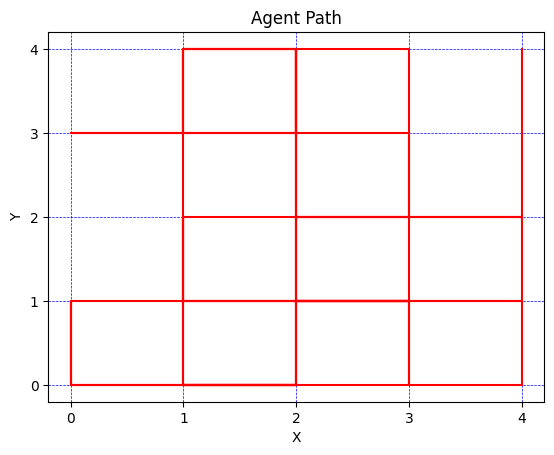

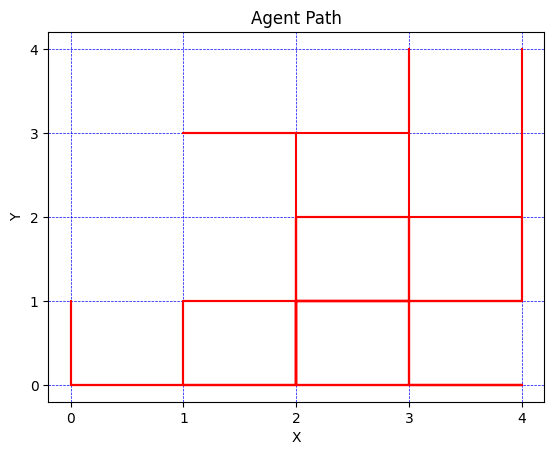

In [89]:
# check the environment
env = RtGridEnv(5,5)
num_episodes = 3

for ep in range(num_episodes):
    total_reward = 0
    obs = env.reset()
    done = False
    while True:
        action = env.action_space.sample()
        new_obs, reward, done, info = env.step(action)
        total_reward += reward
            
        #print(f"episode: {ep}")
        #print(f"obs: {new_obs}, reward: {total_reward}, done: {done}")

        if done:
            break
    
    env.render()

In [46]:
# calculate the environment baseline
num_episodes = 3000
num_timesteps = 0
episode_rewards = []

for ep in range(num_episodes):
    obs = env.reset()
    done = False
    episode_reward = 0.0

    while True:
        action = env.action_space.sample()
        new_obs, reward, done, info = env.step(action)
        episode_reward += reward
        num_timesteps += 1

        if done:
            episode_rewards.append(episode_reward)
            break

# calculate mean_reward
env_mean_random_reward = np.mean(episode_rewards)
env_sd_reward = np.std(episode_rewards)
# calculate number of wins
total_reward = np.sum(episode_rewards)

print()
print("**************")
print(f"Baseline Mean Reward={env_mean_random_reward:.2f}+/-{env_sd_reward:.2f}", end="")
print()
print(f"Baseline won {total_reward} times over {num_episodes} episodes ({num_timesteps} timesteps)")
print(f"Approx {total_reward/num_episodes:.2f} wins per episode")
print("**************")


**************
Baseline Mean Reward=-94.85+/-92.83
Baseline won -284538.0 times over 3000 episodes (317538 timesteps)
Approx -94.85 wins per episode
**************


In [36]:
ray.init(ignore_reinit_error=True)

2023-06-18 11:36:36,389	INFO worker.py:1370 -- Calling ray.init() again after it has already been called.


Python version:,3.10.9
Ray version:,2.2.0


In [81]:
# check the environment
register_env("routing_grid_env", lambda config: RtGridEnv(5,5))
env = RtGridEnv(5,5)

print("checking environment ...")
try:
    check_env(env)
    print("All checks passed. No errors found.")
except:
    print("failed")
    print(check_env(env))

checking environment ...
All checks passed. No errors found.


In [45]:
# configure and build the algorithm
config = (PPOConfig()
          .environment("routing_grid_env")
          .rollouts(num_rollout_workers=2)
          .evaluation(evaluation_interval=15, evaluation_duration=5, evaluation_num_workers=1)
)
algo = config.build()

2023-06-18 11:53:03,392	INFO algorithm_config.py:2503 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2023-06-18 11:53:03,445	INFO algorithm.py:501 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=28938) 2023-06-18 11:53:06,384	WARNING env.py:147 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=29056) 2023-06-18 11:53:10,255	WARNING env.py:147 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. 

In [47]:
# train the agent using Tuner
stop_criteria = dict(time_total_s = 120) # trian for 2 min
tuner = tune.Tuner(
    config.algo_class,
    param_space = config.to_dict(),
    run_config = air.RunConfig(
        local_dir = "SimepleNet_logs",
        stop = stop_criteria,
        verbose = 2
    )
)
experiment_results = tuner.fit()

(PPO pid=29152) 2023-06-18 11:54:50,086	WARNING algorithm_config.py:488 -- Cannot create PPOConfig from given `config_dict`! Property __stdout_file__ not supported.
(PPO pid=29152) 2023-06-18 11:54:50,087	INFO algorithm_config.py:2503 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
(PPO pid=29152) 2023-06-18 11:54:50,683	INFO algorithm.py:501 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=29212) 2023-06-18 11:54:53,972	WARNING env.py:147 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=

Trial name,agent_timesteps_total,counters,custom_metrics,episode_len_mean,episode_media,episode_reward_max,episode_reward_mean,episode_reward_min,episodes_this_iter,info,num_agent_steps_sampled,num_agent_steps_trained,num_env_steps_sampled,num_env_steps_sampled_this_iter,num_env_steps_trained,num_env_steps_trained_this_iter,num_faulty_episodes,num_healthy_workers,num_in_flight_async_reqs,num_remote_worker_restarts,num_steps_trained_this_iter,perf,policy_reward_max,policy_reward_mean,policy_reward_min,sampler_perf,timers
PPO_routing_grid_env_98912_00000,144000,"{'num_env_steps_sampled': 144000, 'num_env_steps_trained': 144000, 'num_agent_steps_sampled': 144000, 'num_agent_steps_trained': 144000}",{},8,{},3,3,3,500,"{'learner': {'default_policy': {'learner_stats': {'cur_kl_coeff': 0.07119140774011612, 'cur_lr': 4.999999873689376e-05, 'total_loss': 3.6781177e-05, 'policy_loss': -7.358338e-06, 'vf_loss': 6.2154473e-09, 'vf_explained_var': 1.0, 'kl': 0.00061993883, 'entropy': 0.48747852, 'entropy_coeff': 0.0, 'model': {}}, 'custom_metrics': {}, 'num_agent_steps_trained': 128.0, 'num_grad_updates_lifetime': 33015.5, 'diff_num_grad_updates_vs_sampler_policy': 464.5}}, 'num_env_steps_sampled': 144000, 'num_env_steps_trained': 144000, 'num_agent_steps_sampled': 144000, 'num_agent_steps_trained': 144000}",144000,144000,144000,4000,144000,4000,0,2,0,0,4000,"{'cpu_util_percent': 40.375, 'ram_util_percent': 52.8}",{},{},{},"{'mean_raw_obs_processing_ms': 0.2821029135737856, 'mean_inference_ms': 0.4428920841083264, 'mean_action_processing_ms': 0.04890616030393777, 'mean_env_wait_ms': 0.03550099200025947, 'mean_env_render_ms': 0.0}","{'training_iteration_time_ms': 3361.732, 'load_time_ms': 0.143, 'load_throughput': 27994687.135, 'learn_time_ms': 1693.658, 'learn_throughput': 2361.752, 'synch_weights_time_ms': 2.403}"


2023-06-18 11:57:00,512	INFO tune.py:762 -- Total run time: 133.29 seconds (132.49 seconds for the tuning loop).


In [48]:
# examine the Ray Tune experiment results, get the appropriate learning rate
df = experiment_results.get_dataframe()

temp_columns = [
    "experiment_id", "config/lr", "config/gamma", "episode_reward_mean",
    "episode_len_mean", "timesteps_total", "training_iteration", 
    "done", "time_total_s", 
    "timers/training_iteration_time_ms", 
    "config/num_workers", "config/evaluation_num_workers",
    "config/num_envs_per_worker"
]
temp = df.loc[:, temp_columns].head()
temp.rename(columns={'config/evaluation_config/num_workers':'num_train_workers'}, inplace=True)
temp.rename(columns={'config/num_envs_per_worker':'num_envs_per_eval_worker'}, inplace=True)
temp.rename(columns={'config/evaluation_num_workers':'evaluation_num_workers'}, inplace=True)
temp.rename(columns={'config/num_workers':'num_rollout_workers'}, inplace=True)
display(temp)

,experiment_id,config/lr,config/gamma,episode_reward_mean,episode_len_mean,timesteps_total,training_iteration,done,time_total_s,timers/training_iteration_time_ms,num_rollout_workers,evaluation_num_workers,num_envs_per_eval_worker
0,b44b3391c9244f3a91cadab2312f487d,0.00005,0.99,3.0,8.0,144000,36,True,120.394912,3361.732,2,1,1


In [82]:
# configure a new agent based on the tuning results obtained above
config2 = (
    PPOConfig()
    .environment(env = "routing_grid_env")
    .rollouts(num_rollout_workers=2)
    .evaluation(evaluation_interval=15, evaluation_duration=5, evaluation_num_workers=1)
    .training(lr=0.00005)
)
algo = config2.build()

(RolloutWorker pid=34595) 2023-06-18 15:10:48,032	WARNING env.py:147 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=34695) 2023-06-18 15:10:52,378	WARNING env.py:147 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2023-06-18 15:10:53,033	WARNING util.py:66 -- Install gputil for GPU system monitoring.


In [83]:
# train the new agent using RLlib.train() in a loop
num_iterations = 20
rewards = []
checkpoint_dir = "saved_runs/SimpleNet/"

for i in range(num_iterations):
    result = algo.train()
    rewards.append(result["episode_reward_mean"])

    # save a checkpoint and evaluate the policy at the end of the training
    if (i==num_iterations-1):
        checkpoint_file = algo.save(checkpoint_dir)
        eval_result = algo.evaluate()

In [84]:
# reload the policy from checkponit and run inference
checkpoint = "./saved_runs/SimpleNet/checkpoint_000020"
#new_config = PPOConfig()
algo = config2.build()
algo.restore(checkpoint)

(RolloutWorker pid=34825) 2023-06-18 15:12:31,595	WARNING env.py:147 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=34925) 2023-06-18 15:12:35,701	WARNING env.py:147 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2023-06-18 15:12:36,338	WARNING util.py:66 -- Install gputil for GPU system monitoring.
2023-06-18 15:12:36,488	INFO trainable.py:790 -- Restored on 192.168.1.69 from checkpoint: saved_runs/SimpleNet/checkpoint_000020
2023-06-18 15:12:36,489	INFO trainable.py:799 -- Current state after restoring: {'_iteration': 20, '_timesteps_total': None, '_time_total': 71.45387

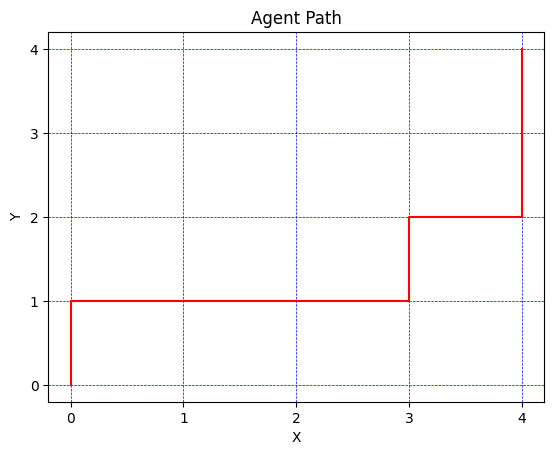

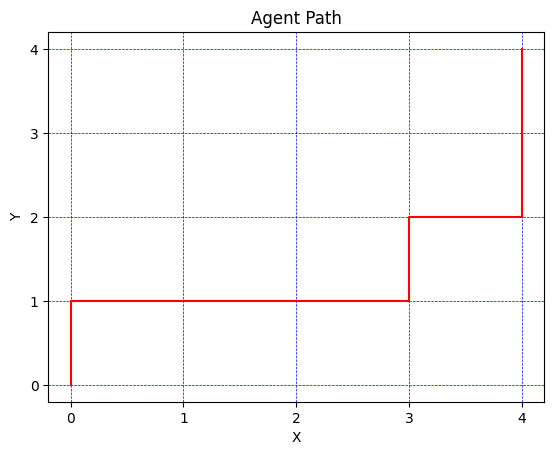

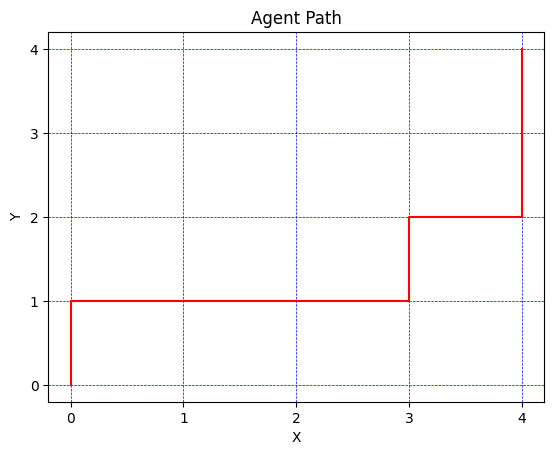

In [90]:
# play and render the game
num_episodes = 3
total_reward = 0

for ep in range(num_episodes):
    obs = env.reset()
    done = False
    while True:
        action = algo.compute_single_action(observation=obs, explore=False)
        obs, reward, done, info = env.step(action)
        total_reward += reward
        
        if done:
            break
        
        #print(f"episode: {ep}")
        #print(f"obs: {new_obs}, reward: {total_reward}, done: {done}")
    env.render()
#env.close()